In [1]:
from __future__ import print_function

import findspark
findspark.init()

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
print(spark)

from pyspark.mllib.linalg import *
from pyspark.mllib.linalg.distributed import *
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

from pyspark.ml.linalg import SparseVector, VectorUDT
from pyspark.sql.types import *
from pyspark.sql.types import StructType, StructField 


import numpy as np
from array import array
import networkx as nx
import scipy as sp
import pandas as pd

## create a dummy network

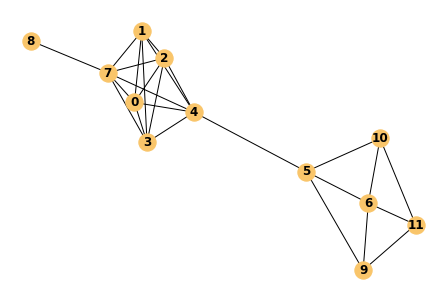

In [4]:
nodes = [0,1,2,3,4,5,6,7,8,9]
edges = [(0,1),(0,2),(0,3),(0,4),(0,7),
         (1,2),(1,3),(1,4),(1,7),
         (2,3),(2,4),(2,7),
         (3,4),(3,7),
         (4,7),
         (4,5),
         (5,6),(5,9),(5,10),
         (6,9),(6,10),(6,11),
         (7,8),
         (9,11),
         (10,11),
        ]

# create graph, add nodes and edges
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
A = nx.adjacency_matrix(G)

# plot
# 'E0E0E0', 'FFCC99', '#82A9D0', '#F9C56A', '#FF9999', '#A4CACA', '#7DCACA' '#F6D66F'
nx.draw(G, with_labels=True, font_weight='bold', node_color='#F9C56A')

In [5]:
# create a pandas dataframe 
graph_df = pd.DataFrame(columns = ['node', 'neighbors'])
graph_df['node'] = list(G.nodes)
graph_df['neighbors'] = graph_df['node'].apply(lambda node: [dst for src,dst in G.edges(node)])
graph_df

,node,neighbors
0,0,"[1, 2, 3, 4, 7]"
1,1,"[0, 2, 3, 4, 7]"
2,2,"[0, 1, 3, 4, 7]"
3,3,"[0, 1, 2, 4, 7]"
4,4,"[0, 1, 2, 3, 7, 5]"
5,5,"[4, 6, 9, 10]"
6,6,"[5, 9, 10, 11]"
7,7,"[0, 1, 2, 3, 4, 8]"
8,8,[7]
9,9,"[5, 6, 11]"


In [6]:
A = nx.adjacency_matrix(G)
A = A.todense()
A

matrix([[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]], dtype=int64)

In [7]:
# Create spark df from pandas df without arrow is still extremely slow! 
# Mostly because Spark must iterate through each row of data 
# and do type checking and conversions from Python to Java for each value, 
# which in tern furces Numpy to convert data to plain Python objects and serialize these to the JVM.

%timeit -r1 df = spark.createDataFrame(graph_df)

31.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
# Now enable Arrow, this can also be done by adding as a line in spark-defaults.conf

spark.conf.set('spark.sql.execution.arrow.enabled', 'true')
df = spark.createDataFrame(graph_df)

In [11]:
df.show()

+----+------------------+
|node|         neighbors|
+----+------------------+
|   0|   [1, 2, 3, 4, 7]|
|   1|   [0, 2, 3, 4, 7]|
|   2|   [0, 1, 3, 4, 7]|
|   3|   [0, 1, 2, 4, 7]|
|   4|[0, 1, 2, 3, 7, 5]|
|   5|     [4, 6, 9, 10]|
|   6|    [5, 9, 10, 11]|
|   7|[0, 1, 2, 3, 4, 8]|
|   8|               [7]|
|   9|        [5, 6, 11]|
|  10|        [5, 6, 11]|
|  11|        [6, 9, 10]|
+----+------------------+



In [12]:
def getVector(lst_neighbors,size):
    '''
    creates vector from neighbor list by computing an "adjacency" array 
    and turns it into pyspark DenseVector 
    '''
    arr = np.zeros(size)
    arr[lst_neighbors] = 1
    return DenseVector(arr)

# There are 3 ways of creating a sparse vector, either works

def get_sparseVec(lst_neighbors, size=df.count()):
    '''
    gets list of node's neighbors and creates pyspark spark vector
    '''
    idx = lst_neighbors
    values = [1]*len(idx)
    return Vectors.sparse(size,idx,values) # I'm passing a list of increasing indices [3,4,5,16,25] and a list of values [1,1,1...N]

def create_sparseVec(lst_neighbors, size=df.count()):
    '''
    gets list of node's neighbors and creates pyspark spark vector
    Create a sparse vector, using either a dictionary, a list of
    (index, value) pairs, or two separate arrays of indices and
    values (sorted by index).

    :param size: Size of the vector.
    :param args: Active entries, as a dictionary {index: value, ...},
    a list of tuples [(index, value), ...], 
    or a list of strictly increasing indices and a list of corresponding values [index, ...],
    [value, ...]. Inactive entries are treated as zeros.
    '''
    lst_dst_val = [(dst,1) for dst in lst_neighbors] # I'm creting a list of tuples [(index, value), ...] to pass as args
    return SparseVector(size, lst_dst_val)

def getSimilarity(fp, vec):
    '''
    shared elements between (fp,vec) / number of non-zero elements in vec
    '''
    return vec.dot(fp).max() / vec.values.sum()

In [24]:
empty_denseVec = getVector([],df.count())

In [45]:
fps = spark.createDataFrame([(0, empty_denseVec) * df.count()], ['num', 'vectors'])

In [13]:
# equivalent to df.neighbors.iloc[0]
x = df.collect()[0]['neighbors']
# x = df.collect()[0][1]
print(x)

y = df.collect()[1]['neighbors']
print(y)

a = get_sparseVec(x)
b = DenseVector(get_sparseVec(y))

sim = getSimilarity(a,b)
print(sim)

# print(type(a.toArray()))
# b.numNonzeros()
# DenseVector(a.toArray())

[1, 2, 3, 4, 7]
[0, 2, 3, 4, 7]
0.8


In [17]:
# can do a dot product with SparseVector and np array
a.dot(getVector([0, 2, 3, 4, 7],df.count()).toArray())

#can do a dot product with a SparseVector and DenseVector
a.dot(getVector([0, 2, 3, 4, 7],df.count()))

4.0

In [51]:
# Broadcast variables allow the programmer to keep a read-only variable cached on each machine rather than shipping a copy of it with tasks
# Created with SparkContext.broadcast()
b = [(1,(1, 4)), (2, (2, 5)), (3, (4,5))]
rdd_b = sc.broadcast(b)
rdd_b.value[0]

(1, (1, 4))

In [ ]:
f = []

In [16]:
# user-defined type (UDT) for Vector
schema = StructType([StructField("fpVec", VectorUDT(), True)])

from pyspark.sql.functions import udf, col, pandas_udf
from pyspark.sql.types import LongType

get_sparsevec = udf(get_sparseVec, schema)
create_sparsevec = udf(create_sparseVec, schema)
get_similarity = udf(getSimilarity, LongType())